In [14]:
# basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [ ]:
### data import need to change path if necessary

data = pd.read_csv("/Users/yvonne_zhu/Desktop/MSDS Capstone/Capstone_EDAV/RData/traffic_cleaned_forPython_k.csv", parse_dates=['day'])
data.set_index('day', inplace=True)
data.sort_index(inplace=True)

### data overview 
data.head()

In [3]:
### One hot encoding

data = pd.get_dummies(data, dtype="bool")
data = data.astype('int')

### To aviod "Do not support special JSON characters in feature name" error in LightGBM
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
# define function for splitting train test

def fun_split_train(train_ratio, 
                           val_ratio, 
                           test_ratio,
                           data,
                           target_col = 'CORE_VL_NbEntry'):
    
    train_size = int(train_ratio * len(data))
    val_size = int(val_ratio * len(data))
    test_size = len(data) - train_size - val_size
    
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size + val_size]
    test_data = data.iloc[-test_size:]
    
    feature_cols = [col for col in data.columns if col != target_col]
    
    X_train, y_train = train_data[feature_cols], train_data[target_col]
    X_val, y_val = val_data[feature_cols], val_data[target_col]
    X_test, y_test = test_data[feature_cols], test_data[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### Cyclical Features Encoding

### Sin and Cos on the entire dataset

In [5]:
# sin and cos transformations on both test and train set

# define function for sin and cos
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data


data_trans = data.reset_index()

data_trans['y'] = data_trans.day.dt.year
data_trans['m'] = data_trans.day.dt.month
data_trans['d'] = data_trans.day.dt.day

data_sincos = encode(data_trans, 'm', 12)
data_sincos = encode(data_trans, 'd', 31)
data_sincos.set_index('day', inplace=True)

# not necessary to transform year into sin cos 

In [6]:
data_sincos.head(5)

,CORE_VL_NbEntry,year,month,Population,MHI,CORE_LB_State_AZ,CORE_LB_State_CA,CORE_LB_State_CO,CORE_LB_State_CT,CORE_LB_State_DC,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,y,m,d,m_sin,m_cos,d_sin,d_cos
day,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40,2016,1,62,65913,1,0,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,71,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,22,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,52,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,25,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953


### light GBM model 
- without transformation
- include state and city

currently, just excluding state and city has higher RMSE; thus, the below model should replace state variable once we find enough census feature to encode this feature

In [7]:
### try on light gbm model

### split using data without transformation
X_train, y_train, X_val, y_val, X_test, y_test = fun_split_train(0.7, 0.2, 0.1, data)
                                                                 

train_lgb = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb, free_raw_data=False)


### hyperparameter  - tunning
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100}


### model fitting
model = lgb.train(params, train_lgb, valid_sets=[val_lgb], early_stopping_rounds=10)

/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 62521, number of used features: 125
[LightGBM] [Info] Start training from score 37.748117
[1]	valid_0's rmse: 30.7689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 29.7121
[3]	valid_0's rmse: 28.7468
[4]	valid_0's rmse: 27.8386
[5]	valid_0's rmse: 27.0283
[6]	valid_0's rmse: 26.2874
[7]	valid_0's rmse: 25.5898
[8]	valid_0's rmse: 24.9656
[9]	valid_0's rmse: 24.3799
[10]	valid_0's rmse: 23.8456
[11]	valid_0's rmse: 23.3424
[12]	valid_0's rmse: 22.8801
[13]	valid_0's rmse: 22.4377
[14]	valid_0's rmse: 22.0233
[15]	valid_0's rmse: 21.6392
[16]	valid_0's rmse: 21.2895
[17]	valid_0's rmse: 20.9865
[18]	valid_0's rmse: 20.7047
[19]	valid_0's r

In [8]:
# Evaluate model on test data
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 13.96


### light GBM model 
- with sin and cos transformation, RMSE is slightly higher than without transformation
- include state and city

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = fun_split_train(0.7, 0.2, 0.1, data_sincos)
                                                                 

train_lgb = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb, free_raw_data=False)


### hyperparameter  - tunning
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100}


### model fitting
model = lgb.train(params, train_lgb, valid_sets=[val_lgb], early_stopping_rounds=10)

/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 62521, number of used features: 132
[LightGBM] [Info] Start training from score 37.748117
[1]	valid_0's rmse: 30.7667
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 29.7167
[3]	valid_0's rmse: 28.7322
[4]	valid_0's rmse: 27.844
[5]	valid_0's rmse: 27.0294
[6]	valid_0's rmse: 26.2411
[7]	valid_0's rmse: 25.5253
[8]	valid_0's rmse: 24.8471
[9]	valid_0's rmse: 24.2279
[10]	valid_0's rmse: 23.6515
[11]	valid_0's rmse: 23.0983
[12]	valid_0's rmse: 22.6358
[13]	valid_0's rmse: 22.1524
[14]	valid_0's rmse: 21.7486
[15]	valid_0's rmse: 21.3617
[16]	valid_0's rmse: 20.9468
[17]	valid_0's rmse: 20.5462
[18]	valid_0's rmse: 20.2264
[19]	valid_0's rm

In [10]:
# Evaluate model on test data
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 14.17


In [11]:
# ! pip install keras
# ! pip install tensorflow

In [31]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error


def train_model_dense(X_train, y_train, X_val, y_val, epochs):
    model = Sequential(
        [
            Dense(10, activation="relu", input_shape=(X_train.shape[1],)),
            Dense(10, activation="relu"),
            Dense(10, activation="relu"),
            Dense(1, activation="linear")
        ]
    )
    model.compile(optimizer=Adam(), loss="mean_squared_error")
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    return model, history


# build model on unencoded data
X_train, y_train, X_val, y_val, X_test, y_test = fun_split_train(0.7, 0.2, 0.1, data)
unencode_model, unencode_history = train_model_dense(X_train, y_train, X_val, y_val, epochs=5)

mse_unencoded = mean_squared_error(y_test, unencode_model.predict(X_test))


# build model on encoded data
X_train, y_train, X_val, y_val, X_test, y_test = fun_split_train(0.7, 0.2, 0.1, data_sincos)
encode_model, encode_history = train_model_dense(X_train, y_train, X_val, y_val, epochs=5)

mse_encoded = mean_squared_error(y_test, encode_model.predict(X_test))

Epoch 1/5
1954/1954 [==============================] - 3s 1ms/step - loss: 233705.9062 - val_loss: 1060.7114
Epoch 2/5
1954/1954 [==============================] - 3s 1ms/step - loss: 1037.7701 - val_loss: 1027.2321
Epoch 3/5
1954/1954 [==============================] - 3s 1ms/step - loss: 1036.2791 - val_loss: 1019.8461
Epoch 4/5
1954/1954 [==============================] - 3s 1ms/step - loss: 1053.4358 - val_loss: 1018.9901
Epoch 5/5
280/280 [==============================] - 0s 991us/step
Epoch 1/5
1954/1954 [==============================] - 3s 1ms/step - loss: 1050.2981 - val_loss: 1060.4423
Epoch 2/5
1954/1954 [==============================] - 2s 1ms/step - loss: 1029.1605 - val_loss: 1009.4909
Epoch 3/5
1954/1954 [==============================] - 2s 1ms/step - loss: 1023.2253 - val_loss: 1004.4053
Epoch 4/5
1954/1954 [==============================] - 2s 1ms/step - loss: 1015.6573 - val_loss: 1007.1956
Epoch 5/5
280/280 [==============================] - 0s 756us/step


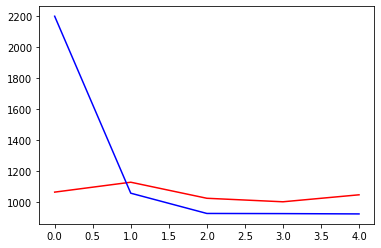

In [23]:
plt.plot(unencode_history.history['val_loss'], "r")
ax = plt.plot(encode_history.history['val_loss'], "b")

In [35]:
# evaluate on test set
print(np.sqrt(mse_encoded))
print(np.sqrt(mse_unencoded))

23.54927206805753
22.58852330164964


### Time Series Approach

### Prophet

In [41]:
# define function for spliting time series data alone

def spliting_ts_train_test(train_ratio, 
                           val_ratio, 
                           test_ratio,
                           data):
    
    train_size = int(train_ratio * len(data))
    val_size = int(val_ratio * len(data))
    test_size = len(data) - train_size - val_size
    
    ts_data = pd.DataFrame(data).reset_index()
    ts_data = ts_data.rename(columns = {'day': 'ds', 'CORE_VL_NbEntry': 'y'})
    
    
    ts_train = ts_data.iloc[:train_size]
    ts_val = ts_data.iloc[train_size:train_size + val_size]
    ts_test = ts_data.iloc[-test_size:]

    return ts_train, ts_val, ts_test

In [45]:
### adding holiday indicator to prophet
holiday_raw = pd.read_excel('/Users/yvonne_zhu/Desktop/MSDS Capstone/Capstone_EDAV/RData/US_holiday_labelled.xlsx')
df_holiday = holiday_raw[['Date','Holiday']].rename(columns = {'Date': 'ds','Holiday': 'holiday'})

In [46]:
# check prophet version
import prophet
# print version number
print('Prophet %s' % prophet.__version__)

Prophet 1.1.2


In [48]:
from prophet import Prophet 
prophet_model = Prophet(interval_width = 0.95, holidays=df_holiday, daily_seasonality=True)

ts_train, ts_val, ts_test = spliting_ts_train_test(0.7, 0.2, 0.1, data)
prophet_model.fit(ts_train[['ds','y']])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [61]:
# output RMSE for model 
forecast_y = prophet_model.predict(ts_test[['ds']])
mean_squared_error(ts_test['y'],forecast_y['yhat'],squared=False)

21.861650029452843

### LSTM model

https://arxiv.org/pdf/2205.06673.pdf

In [64]:
# ! pip install keras_preprocessing

     |████████████████████████████████| 42 kB 1.9 MB/s eta 0:00:01


In [67]:
### get ready
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve

from sklearn.preprocessing import LabelEncoder

from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.layers import Activation, Dense, Dropout, Embedding, LSTM

import re

from IPython.display import display

import os

import string

import time

import random

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb

In [71]:
### Vanilla LSTM

# define model, training dataset [samples, timesteps, features]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 137)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')


In [77]:
data_trans.head()

,CORE_VL_NbEntry,year,month,Population,MHI,CORE_LB_State_AZ,CORE_LB_State_CA,CORE_LB_State_CO,CORE_LB_State_CT,CORE_LB_State_DC,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,y,m,d,m_sin,m_cos,d_sin,d_cos
day,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40,2016,1,62,65913,1,0,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,71,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,22,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,52,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953
2016-01-01,25,2016,1,253,84097,0,1,0,0,0,...,0,0,0,2016,1,1,0.5,0.866025,0.201299,0.97953


In [80]:
# first try on univariate data without transformation

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
lstm_data = min_max_scaler.fit_transform(data['CORE_VL_NbEntry'].values.reshape(-1,1))

# note that lstm_data only contains y value but not multivariables

array([[0.06700168],
       [0.11892797],
       [0.03685092],
       ...,
       [0.08877722],
       [0.05527638],
       [0.0519263 ]])

In [85]:
lstm_train, lstm_val, lstm_test = spliting_ts_train_test(0.7,0.2,0.1,lstm_data)

# currently define look back date as 30 days

def create_lookback(data, look_back=30):
    dataX, dataY = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i+look_back],0)
    
    return np.array(dataX), np.array(dataY)

,index,0
0,0,0.067002
1,1,0.118928
2,2,0.036851
3,3,0.087102
4,4,0.041876


In [87]:
x_train, y_train = create_lookback(lstm_train, look_back=30)

TypeError: '(slice(0, 30, None), 0)' is an invalid key